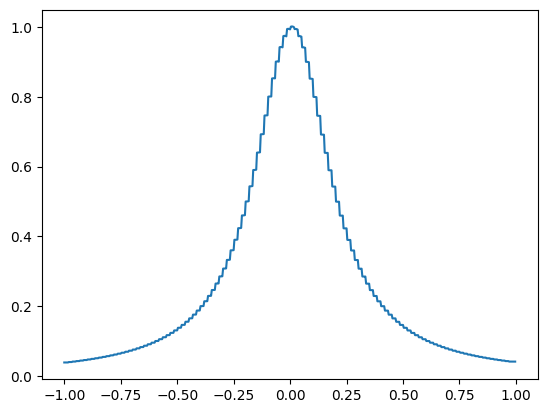

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x):
    return 1/(1+25*x*x)

def f2(x):
    return np.exp(np.cos(x))

def lagrange_polynomial(x_values, y_values, x):
    sol = 0
    t = 0
    for i in range(0, len(x_values)):
        t = 1
        for j in range(0, len(y_values)):
            if(j != i):
                t = t*((x-x_values[j])/(x_values[i]-x_values[j]))
        sol += t*y_values[i]
    return sol

#transforms chebyshew points to interval [a,b]

def transform_cheb(nodes, a, b):
    for i in range(len(nodes)):
        nodes[i] = a+(b-a)*(nodes[i]+1)/2

#calculates n standard chebyshew points on interval[1,1]
  
def get_nodes_cheb(n):
    nodes = np.empty(shape=n, dtype=float)
    for i in range(n):
        nodes[i] = np.cos(np.pi*(2*i+1)/(2*n+2))
    return nodes

#gets n equidistant nodes in interval [a,b] 

def get_eqdist(n, a, b):
    nodes = np.empty(shape=n, dtype=float)
    h = (b-a)/n
    for i in range(n):
        nodes[i] = a+h*i        
    nodes[n-1] = b
    return nodes

#calculates sigmas in matrix equation (strona 17)

def qubic_simas_hs(nodes, y_values):
    n = len(nodes) - 1
    hs = np.zeros(shape=n)
    for i in range(n):
        hs[i] = nodes[i+1] - nodes[i]
    h_matrix = np.zeros(shape=(n+1, n+1))
    h_matrix[0][0] = -hs[0]
    h_matrix[0][1] = hs[0]
    h_matrix[n-1][n-2] = hs[n-1]
    h_matrix[n][n] = -hs[n-1]
    for i in range(1,n):
        h_matrix[i][i-1] = hs[i-1]
        h_matrix[i][i] = 2*(hs[i-1]+hs[i])
        h_matrix[i][i+1] = hs[i]
    a = coefficient(nodes, y_values)
    b = coefficient(nodes[n-3:], y_values[n-3:])
    d_matrix = np.zeros(shape=n+1)
    d_matrix[0] = hs[0]*hs[0]*a[3]
    d_matrix[n] = -hs[n-1]*hs[n-1]*b[3]
    for i in range(1,n):
        d_matrix[i] = (y_values[i+1]-y_values[i])/hs[i] - (y_values[i]-y_values[i-1])/hs[i-1]
    return np.linalg.solve(h_matrix,d_matrix),hs

#calculates those fucked up deltas raised to power

def coefficient(x, y):
    """
    x: list or np array contanining x data points
    y: list or np array contanining y data points
    """

    m = len(x)
    x = np.array(x,dtype=float)
    a = np.array(y,dtype=float)
    for k in range(1, m):
        a[k:m] = (a[k:m] - a[k - 1])/(x[k:m] - x[k - 1])
    return a

def spline_value(nodes, y_values, sigmas, hs, x):
    n = len(nodes)
    if x < nodes[0] or x > nodes[n-1]:
        return None
    for i in range(0,n-1):
        if nodes[i] <= x <= nodes[i+1]:
            k = i
    b = (y_values[k+1]-y_values[k])-hs[k]*(sigmas[k+1]+2*sigmas[k])
    c = 3*sigmas[k]
    d = (sigmas[k+1]-sigmas[k])/hs[k]
    return y_values[k] + b*(x-nodes[k]) + c*((x-nodes[k])**2) + d*((x-nodes[k])**3)

if __name__ == "__main__":
    # sig, hs = qubic_simas_hs(x, y)
    # print(spline_value(x,y,sig,hs,))
    # mat
    x_eq = get_eqdist(12,-1,1)
    y_eq = [f1(x) for x in x_eq]
    x_ch = get_nodes_cheb(12)
    y_ch = [f1(x) for x in x_ch]
    sig, hs = qubic_simas_hs(x_eq, y_eq)
    
    x_space = np.arange(-1, 1, 1/300)
    y_edist_spl = [spline_value(x_eq,y_eq,sig,hs,x) for x in x_space]
    y_eqdist_lag = [lagrange_polynomial(x_eq,y_eq,x) for x in x_space]
    y_cheb_lag = [lagrange_polynomial(x_ch,y_ch,x) for x in x_space]
    # plt.plot(x_space,y_eqdist_lag)
    plt.plot(x_space,y_edist_spl)
    # plt.plot(x_space,[f1(x) for x in x_space])

    pass